In [ ]:
#Shuvani Choudhury (12768553)
#Purpose of code: Fit MM-ARX-GARCH models to test for abnormal returns in individual stock indices during the pandemic

In [100]:
#Import relevant packages
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from arch.univariate import ARCH, GARCH, EGARCH
from arch import arch_model
from statsmodels.compat import lzip
from scipy import stats
import arch
from statsmodels.stats.diagnostic import het_white
from statistics import stdev
from arch.univariate import LS
from arch.univariate import ARX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import ttest_1samp
from pylab import *
from tikzplotlib import save as tikz_save

In [101]:
#Read excel file and calculate the log-returns
df = pd.read_excel('data.xlsx', index_col=0)
df['log_ret_USA'] = 100*(np.log(df.USA) - np.log(df.USA.shift(1)))
df['log_ret_JAP'] = 100*(np.log(df.Japan) - np.log(df.Japan.shift(1)))
df['log_ret_NL'] = 100*(np.log(df.Netherlands) - np.log(df.Netherlands.shift(1)))
df['log_ret_GER'] = 100*(np.log(df.Germany) - np.log(df.Germany.shift(1)))
df['log_ret_BR'] = 100*(np.log(df.Brazil) - np.log(df.Brazil.shift(1)))
df['log_ret_HK'] = 100*(np.log(df.HK) - np.log(df.HK.shift(1)))
df['log_ret_SA'] = 100*(np.log(df.SA) - np.log(df.SA.shift(1)))
df['log_ret_SK'] = 100*(np.log(df.SK) - np.log(df.SK.shift(1)))
df['log_ret_AU'] = 100*(np.log(df.Australia) - np.log(df.Australia.shift(1)))
df['log_ret_IND'] = 100*(np.log(df.India) - np.log(df.India.shift(1)))
df['log_ret_MSCI'] = 100*(np.log(df.MSCI) - np.log(df.MSCI.shift(1)))
df.head()

USA         Japan  Netherlands    Germany   Brazil  \
Date                                                                       
Dec 03, 2018  2790.370117  22574.759766   523.869995  25.966000  89820.0   
Dec 04, 2018  2700.060059  22036.050781   523.229980  25.200001  88624.0   
Dec 06, 2018  2695.949951  21501.619141   498.920013  24.910000  88846.0   
Dec 07, 2018  2633.080078  21678.679688   503.980011  24.444000  88115.0   
Dec 10, 2018  2637.719971  21219.500000   495.309998  24.350000  85915.0   

                        HK            SA           SK  Australia  \
Date                                                               
Dec 03, 2018  27182.039063  10209.959961  2131.929932  54.180000   
Dec 04, 2018  27260.439453  10263.990234  2114.350098  53.660000   
Dec 06, 2018  26156.380859   9893.459961  2068.689941  53.099998   
Dec 07, 2018  26063.759766   9946.290039  2075.760010  53.349998   
Dec 10, 2018  25752.380859   9754.330078  2053.790039  52.169998   

                     India  ...  log_ret_JAP  log_ret_NL  log_ret_GER  \
Date                        ...                                         
Dec 03, 2018  36241.000000  ...          NaN         NaN          NaN   
Dec 04, 2018  36134.308594  ...    -2.415267   -0.122245    -2.994396   
Dec 06, 2018  35312.128906  ...    -2.455154   -4.757531    -1.157470   
Dec 07, 2018  35673.250000  ...     0.820103    1.009082    -1.888454   
Dec 10, 2018  34959.718750  ...    -2.140870   -1.735278    -0.385294   

              log_ret_BR  log_ret_HK  log_ret_SA  log_ret_SK  log_ret_AU  \
Date                                                                       
Dec 03, 2018         NaN         NaN         NaN         NaN         NaN   
Dec 04, 2018   -1.340497    0.288012    0.527797   -0.828016   -0.964399   
Dec 06, 2018    0.250183   -4.134338   -3.676775   -2.183195   -1.049095   
Dec 07, 2018   -0.826175   -0.354734    0.532569    0.341183    0.469705   
Dec 10, 2018   -2.528434   -1.201875   -1.948832   -1.064047   -2.236636   

              log_ret_IND  log_ret_MSCI  
Date                                     
Dec 03, 2018          NaN           NaN  
Dec 04, 2018    -0.294828     -2.169750  
Dec 06, 2018    -2.301629     -1.574194  
Dec 07, 2018     1.017461     -1.090024  
Dec 10, 2018    -2.020460     -0.821360  

[5 rows x 22 columns]

In [102]:
#Split the dataset into training and test datasets
df_tr=df.iloc[:186].dropna()
df_test=df.iloc[186:].dropna()
ret_test=df_test.iloc[:,11:21]
mkt_tr=df_tr.iloc[:,21].dropna()
print(mkt_tr)

Date
Dec 04, 2018   -2.169750
Dec 06, 2018   -1.574194
Dec 07, 2018   -1.090024
Dec 10, 2018   -0.821360
Dec 11, 2018    0.099821
Dec 12, 2018    1.139249
Dec 13, 2018    0.015909
Dec 14, 2018   -1.584128
Dec 18, 2018   -1.675343
Dec 19, 2018   -0.626465
Dec 20, 2018   -1.506293
Dec 21, 2018   -1.335178
Dec 27, 2018    1.194054
Dec 28, 2018    0.539898
Jan 04, 2019    1.562921
Jan 07, 2019    0.888312
Jan 08, 2019    0.686215
Jan 09, 2019    0.916254
Jan 10, 2019    0.349443
Jan 11, 2019   -0.003200
Jan 15, 2019    0.329100
Jan 16, 2019    0.172106
Jan 17, 2019    0.387745
Jan 18, 2019    1.216990
Jan 22, 2019   -1.039510
Jan 23, 2019    0.072802
Jan 24, 2019    0.233874
Jan 29, 2019    0.384386
Jan 30, 2019    0.985692
Jan 31, 2019    0.926722
                  ...   
Sep 26, 2019    0.011616
Sep 27, 2019   -0.401549
Sep 30, 2019    0.160231
Oct 04, 2019   -1.100553
Oct 10, 2019   -0.132530
Oct 11, 2019    1.355268
Oct 15, 2019    0.799240
Oct 16, 2019    0.011536
Oct 17, 2019    0.29

       log_ret_USA  log_ret_JAP  log_ret_NL  log_ret_GER  log_ret_BR  \
count   181.000000   181.000000  181.000000   181.000000  181.000000   
mean      0.067518     0.013208    0.076380     0.029141    0.107035   
std       0.937056     1.099578    0.946327     1.272256    1.303512   
min      -3.290023    -3.052643   -4.757531    -5.150624   -4.491411   
25%      -0.294870    -0.531412   -0.284878    -0.537925   -0.581809   
50%       0.123110     0.054046    0.140009     0.027342    0.223707   
75%       0.573634     0.588241    0.664211     0.757131    0.900325   
max       2.944283     3.824962    2.926353     5.243601    4.400692   

       log_ret_HK  log_ret_SA  log_ret_SK  log_ret_AU  log_ret_IND  \
count  181.000000  181.000000  181.000000  181.000000   181.000000   
mean    -0.022339    0.004014   -0.013867    0.070766     0.050010   
std      1.173045    1.089174    0.938771    0.864337     1.000214   
min     -4.134338   -3.676775   -3.504915   -2.796117    -2.604316   
2

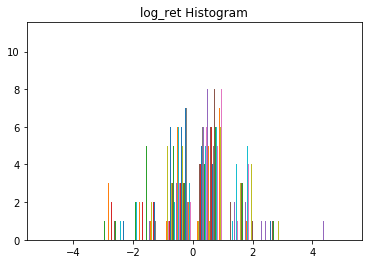

In [103]:
#Replace original stock-index prices with stock-index return values
dataset=df_tr.iloc[:,11:22].dropna()
df_tr2=df_tr.iloc[:,11:21].dropna()
df_test2=df_test.iloc[:,11:21].dropna()

#Print descriptive statistics of resultant dataset
print(dataset.describe())
print(dataset.kurtosis());
print(dataset.skew());
plt.hist(dataset);
plt.title('log_ret Histogram');

In [104]:
#Run the Augmented Dickey-Fuller test on the training dataset to look for unit roots

name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC']
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_USA, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC']
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_JAP, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC']
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_NL, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC'] #Yielded 2 lags
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_GER, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC'] #Yielded 1 lag
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_BR, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC'] #Yielded 1 lag
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_HK, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC'] 
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_SA, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC'] #Yielded 1 lag
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_SK, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC']
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_AU, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC'] #Yielded 2 lags
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_IND, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));

[('Test statistic', -13.039790207434033), ('p-value', 9.252357392081095e-24), ('No. lags', 0), ('No. obs', 180), ('Critical values', {'1%': -2.5782730555555555, '5%': -1.9425907265089164, '10%': -1.6154238607681755}), ('AIC', 408.72457162435217)]
[('Test statistic', -14.045296290367784), ('p-value', 2.313724383220614e-25), ('No. lags', 0), ('No. obs', 180), ('Critical values', {'1%': -2.5782730555555555, '5%': -1.9425907265089164, '10%': -1.6154238607681755}), ('AIC', 478.6982906545788)]
[('Test statistic', -12.523115425452099), ('p-value', 7.541577770053862e-23), ('No. lags', 0), ('No. obs', 180), ('Critical values', {'1%': -2.5782730555555555, '5%': -1.9425907265089164, '10%': -1.6154238607681755}), ('AIC', 404.1870346283669)]
[('Test statistic', -8.6365302188374), ('p-value', 1.1554129607554287e-14), ('No. lags', 2), ('No. obs', 178), ('Critical values', {'1%': -2.578415148339856, '5%': -1.942609657552318, '10%': -1.61540902618413}), ('AIC', 535.5662905420904)]
[('Test statistic', -

In [105]:
#Make structural changes to the exogenous variable for syntax purposes
mkt_tr2 = np.array(mkt_tr.values.tolist());
mkt_tr2 = mkt_tr2.reshape(len(mkt_tr2), 1);

In [106]:
#Fit appropriate mean models to each time-series
ls_USA = ARX(df_tr2.log_ret_USA, mkt_tr2, lags=[1,3,4,7,9,10,11,13], constant=True);
ls_JAP = ARX(df_tr2.log_ret_JAP, mkt_tr2, lags=[1,4,6,8,9,10,11,12,13,14,15], constant=True);
ls_NL = ARX(df_tr2.log_ret_NL, mkt_tr2, lags=[11,14], constant=True);
ls_GER = ARX(df_tr2.log_ret_GER, mkt_tr2, lags=[1,2,10])
ls_BR = LS(df_tr2.log_ret_BR, mkt_tr2, constant=True);
ls_HK = ARX(df_tr2.log_ret_HK, mkt_tr2, lags=[1,3,8], constant=True);
ls_SA = ARX(df_tr2.log_ret_SA, mkt_tr2, lags=1, constant=True);
ls_SK = ARX(df_tr2.log_ret_SK, mkt_tr2, lags=1, constant=True);
ls_AU = ARX(df_tr2.log_ret_AU, mkt_tr2, lags=1, constant=True);
ls_IND = LS(df_tr2.log_ret_IND, mkt_tr2, constant=True)

In [107]:
#Fit appropriate volatility models to each time-series
ls_USA.distibution = 'Normal';
ls_USA.volatility = GARCH(p=5,q=1);
res_USA = ls_USA.fit(update_freq=0, disp='off');
print(res_USA.summary());
ls_JAP.distibution = 'Normal';
ls_JAP.volatility = GARCH(p=20,q=0);
res_JAP = ls_JAP.fit(update_freq=0, disp='off');
print(res_JAP.summary());
ls_NL.distibution = 'Normal';
ls_NL.volatility = GARCH(p=2, q=0);
res_NL = ls_NL.fit(update_freq=0, disp='off');
print(res_NL.summary());
ls_GER.distibution = 'Normal';
ls_GER.volatility = GARCH(p=5,q=2);
res_GER = ls_GER.fit();
print(res_GER.summary());
ls_BR.distibution = 'Normal';
ls_BR.volatility = GARCH(p=1,q=0);
res_BR = ls_BR.fit();
print(res_BR.summary());
ls_HK.distibution = 'Normal';
ls_HK.volatility = GARCH(p=8,q=2);
res_HK = ls_HK.fit();
print(res_HK.summary());
ls_SA.distibution = 'Normal';
ls_SA.volatility = GARCH(p=3,q=2);
res_SA = ls_SA.fit(update_freq=0, disp='off');
print(res_SA.summary());
ls_SK.distibution = 'Normal';
ls_SK.volatility = GARCH(p=2,q=0);
res_SK = ls_SK.fit();
print(res_SK.summary());
ls_AU.distibution = 'Normal';
ls_AU.volatility = GARCH(p=2,q=3);
res_AU = ls_AU.fit(update_freq=0, disp='off');
print(res_AU.summary());
ls_IND.distibution = 'Normal';
ls_IND.volatility = GARCH(p=3,q=1);
res_IND = ls_IND.fit();
print(res_IND.summary());

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06132. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.6791. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


                          AR-X - GARCH Model Results                          
Dep. Variable:            log_ret_USA   R-squared:                       0.906
Mean Model:                      AR-X   Adj. R-squared:                  0.901
Vol Model:                      GARCH   Log-Likelihood:                1.96854
Distribution:                  Normal   AIC:                           30.0629
Method:            Maximum Likelihood   BIC:                           83.1703
                                        No. Observations:                  168
Date:                Sun, Aug 09 2020   Df Residuals:                      151
Time:                        16:16:12   Df Model:                           17
                                    Mean Model                                    
                      coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------------------------------------------
Const               0.0385  2.442e-02   

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2435. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9472. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc


Iteration:      7,   Func. Count:    136,   Neg. LLF: 220.90440045360282
Iteration:      8,   Func. Count:    156,   Neg. LLF: 220.8650481845258
Iteration:      9,   Func. Count:    176,   Neg. LLF: 220.78317901657988
Iteration:     10,   Func. Count:    195,   Neg. LLF: 220.55028294377593
Iteration:     11,   Func. Count:    213,   Neg. LLF: 218.88431002006152
Iteration:     12,   Func. Count:    231,   Neg. LLF: 217.9878821787269
Iteration:     13,   Func. Count:    250,   Neg. LLF: 217.7845701652913
Iteration:     14,   Func. Count:    269,   Neg. LLF: 217.75346759522202
Iteration:     15,   Func. Count:    287,   Neg. LLF: 217.70379348317647
Iteration:     16,   Func. Count:    305,   Neg. LLF: 217.68513894803175
Iteration:     17,   Func. Count:    323,   Neg. LLF: 217.68418706233635
Iteration:     18,   Func. Count:    341,   Neg. LLF: 217.6841467987749
Iteration:     19,   Func. Count:    359,   Neg. LLF: 217.6841432415411
Optimization terminated successfully.    (Exit mode 0)


                          AR-X - GARCH Model Results                          
Dep. Variable:             log_ret_AU   R-squared:                       0.123
Mean Model:                      AR-X   Adj. R-squared:                  0.113
Vol Model:                      GARCH   Log-Likelihood:               -216.069
Distribution:                  Normal   AIC:                           450.138
Method:            Maximum Likelihood   BIC:                           478.875
                                        No. Observations:                  180
Date:                Sun, Aug 09 2020   Df Residuals:                      171
Time:                        16:16:13   Df Model:                            9
                                  Mean Model                                  
                    coef    std err          t      P>|t|     95.0% Conf. Int.
------------------------------------------------------------------------------
Const             0.0539  6.245e-02      0.863      

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.828. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.6848. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSca

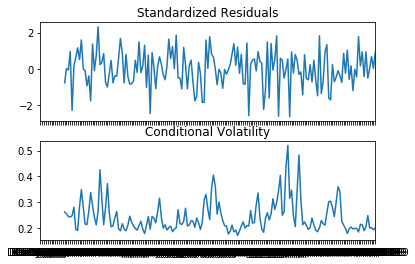

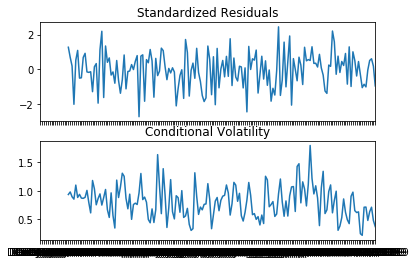

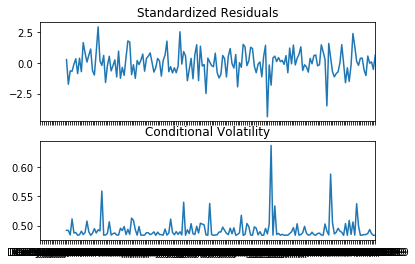

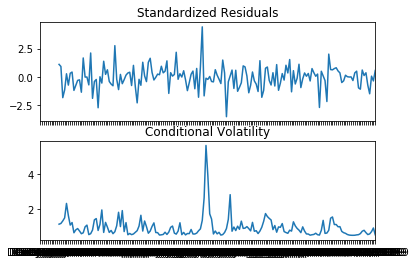

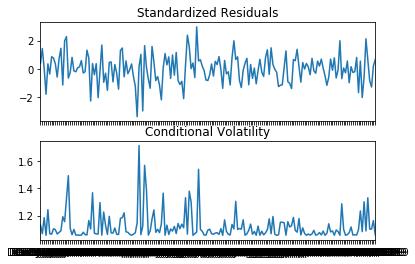

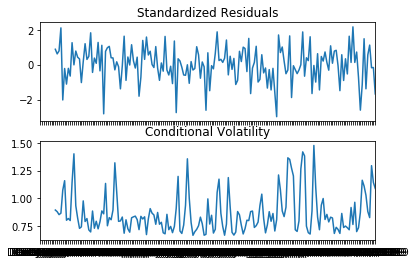

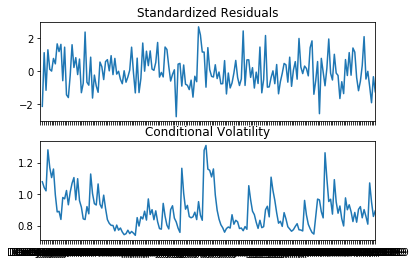

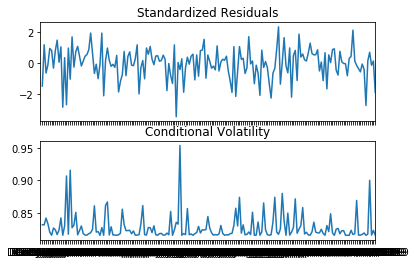

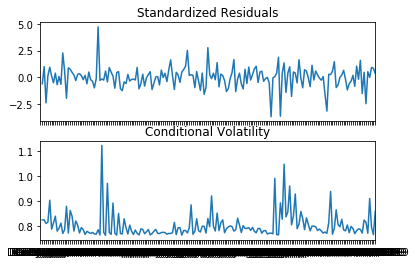

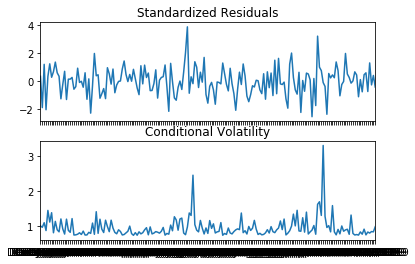

In [108]:
#Check residuals and conditional volatility for mean-reversion and trends
fig_USA=res_USA.plot()
fig_JAP=res_JAP.plot()
fig_NL=res_NL.plot()
fig_GER=res_GER.plot()
fig_BR=res_BR.plot()
fig_HK=res_HK.plot()
fig_SA=res_SA.plot()
fig_SK=res_SK.plot()
fig_AU=res_AU.plot()
fig_IND=res_IND.plot()

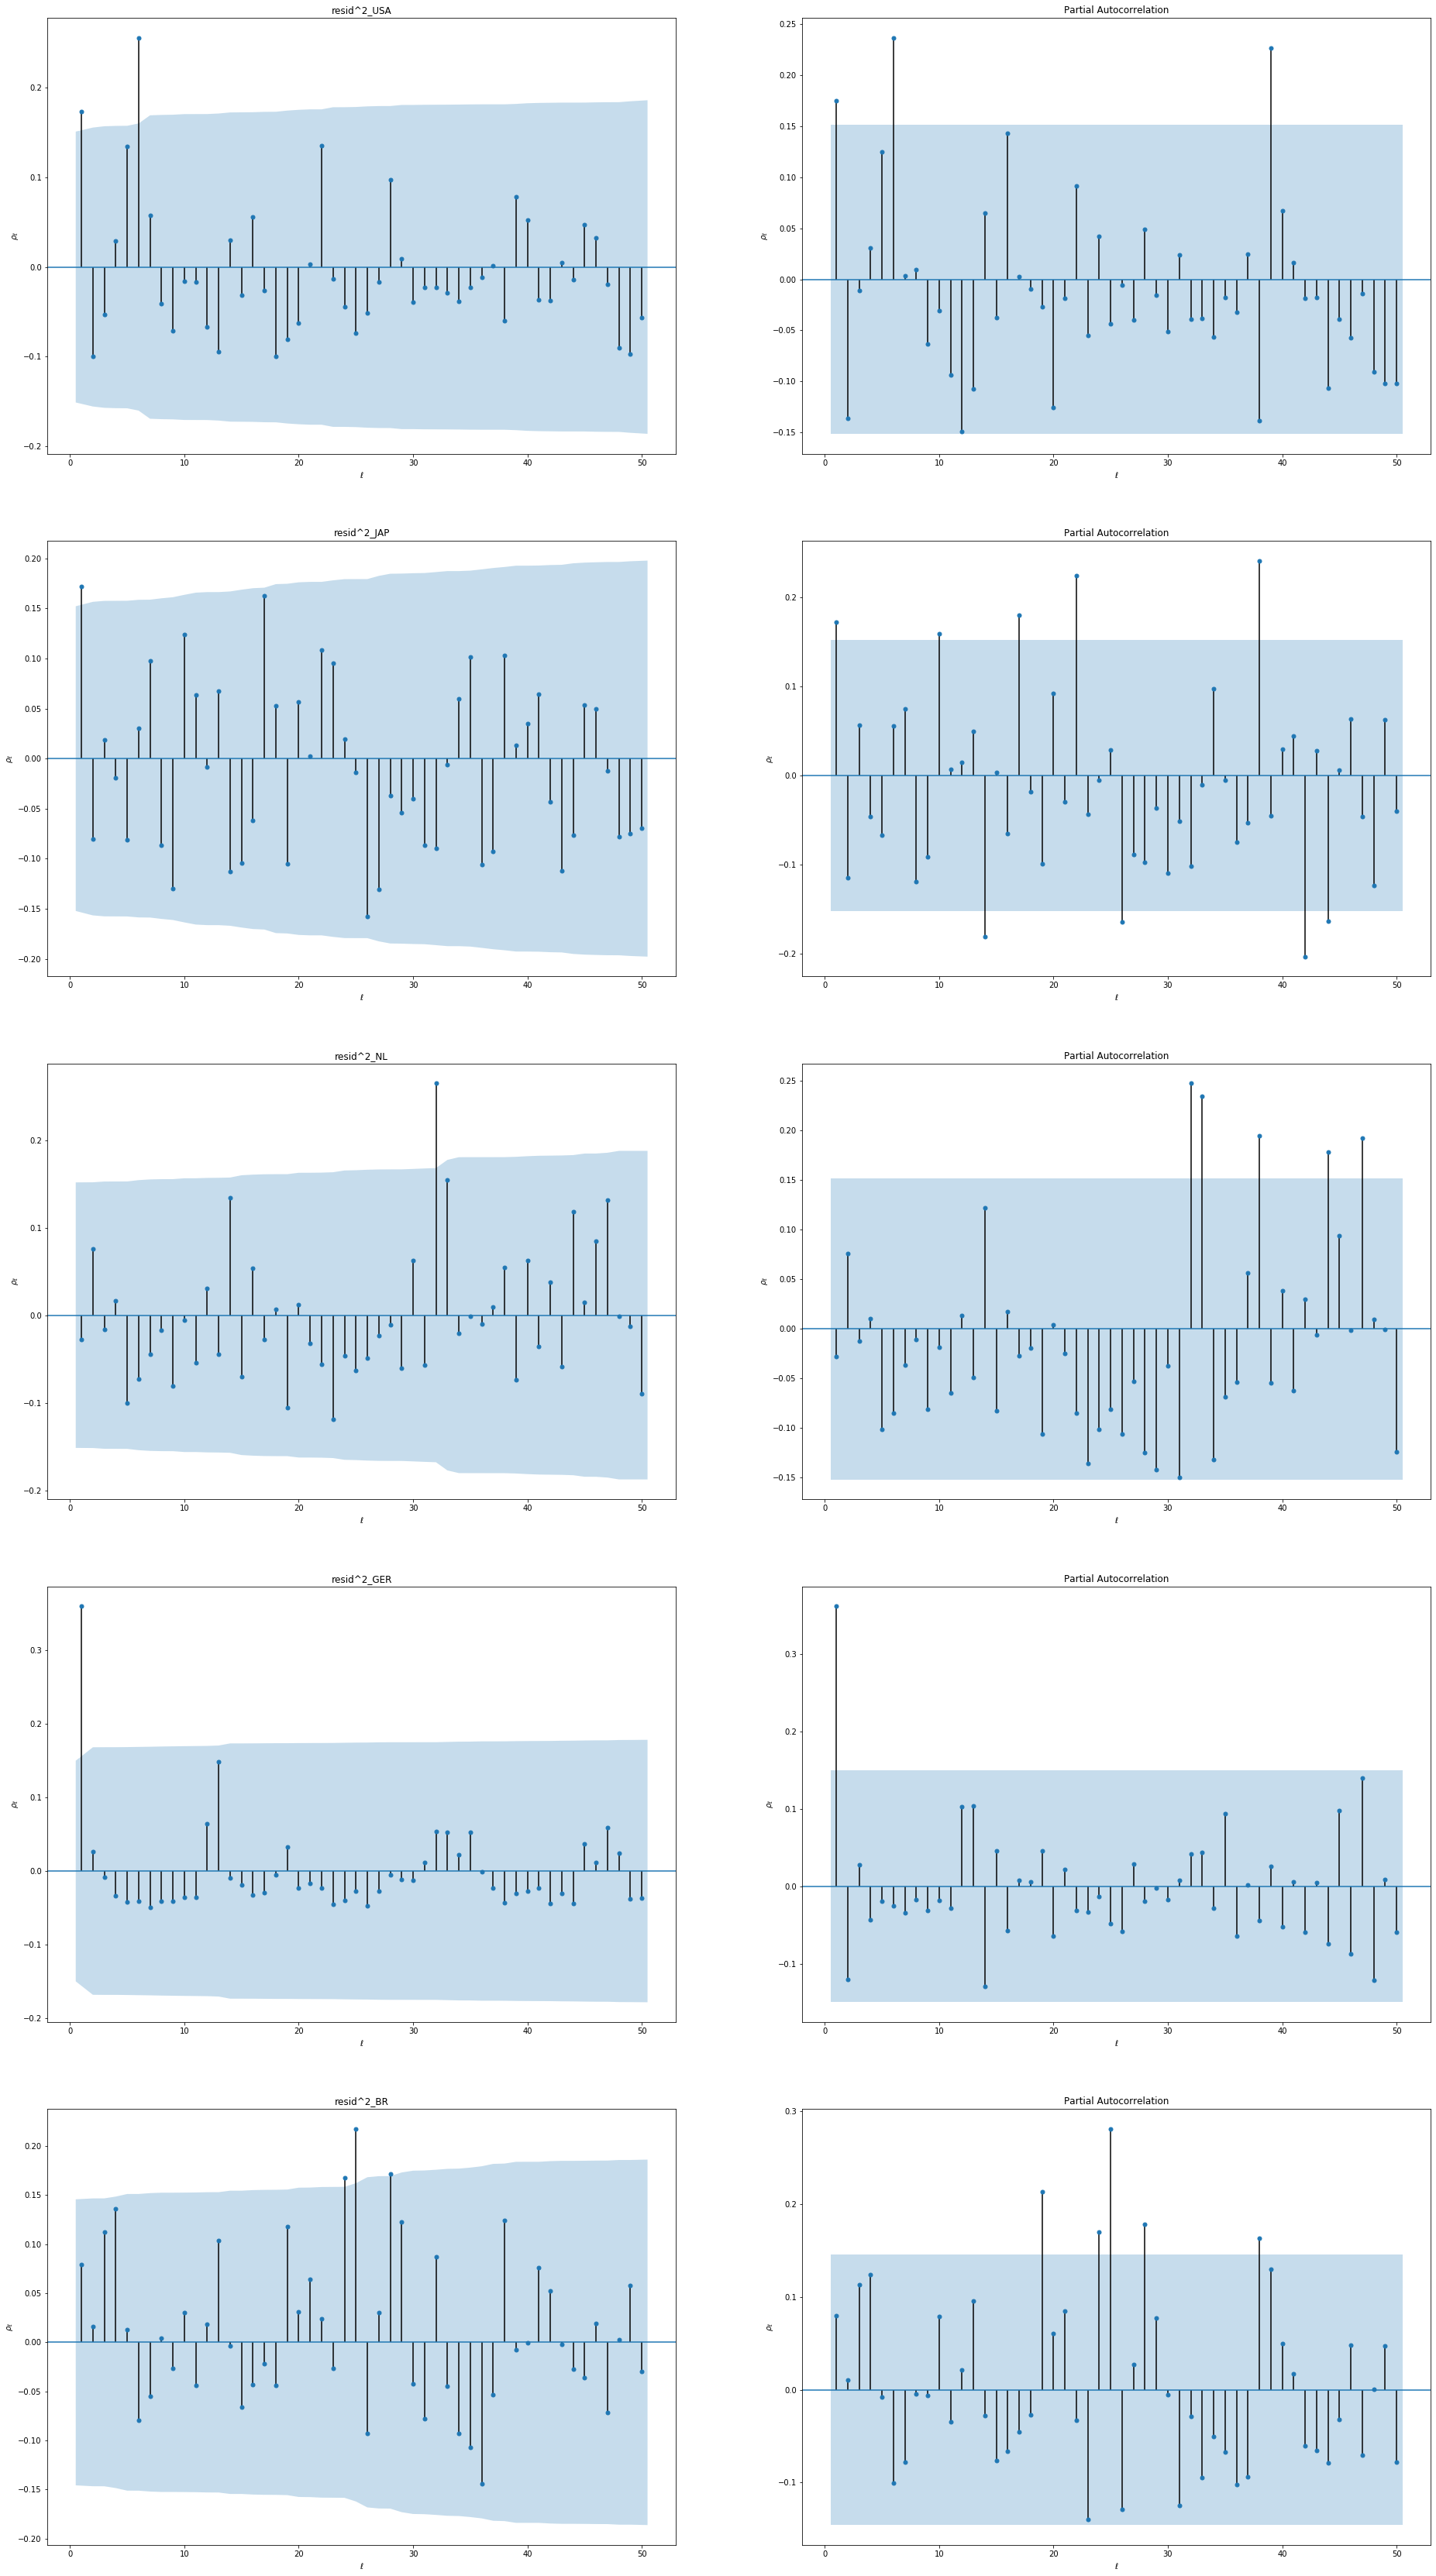

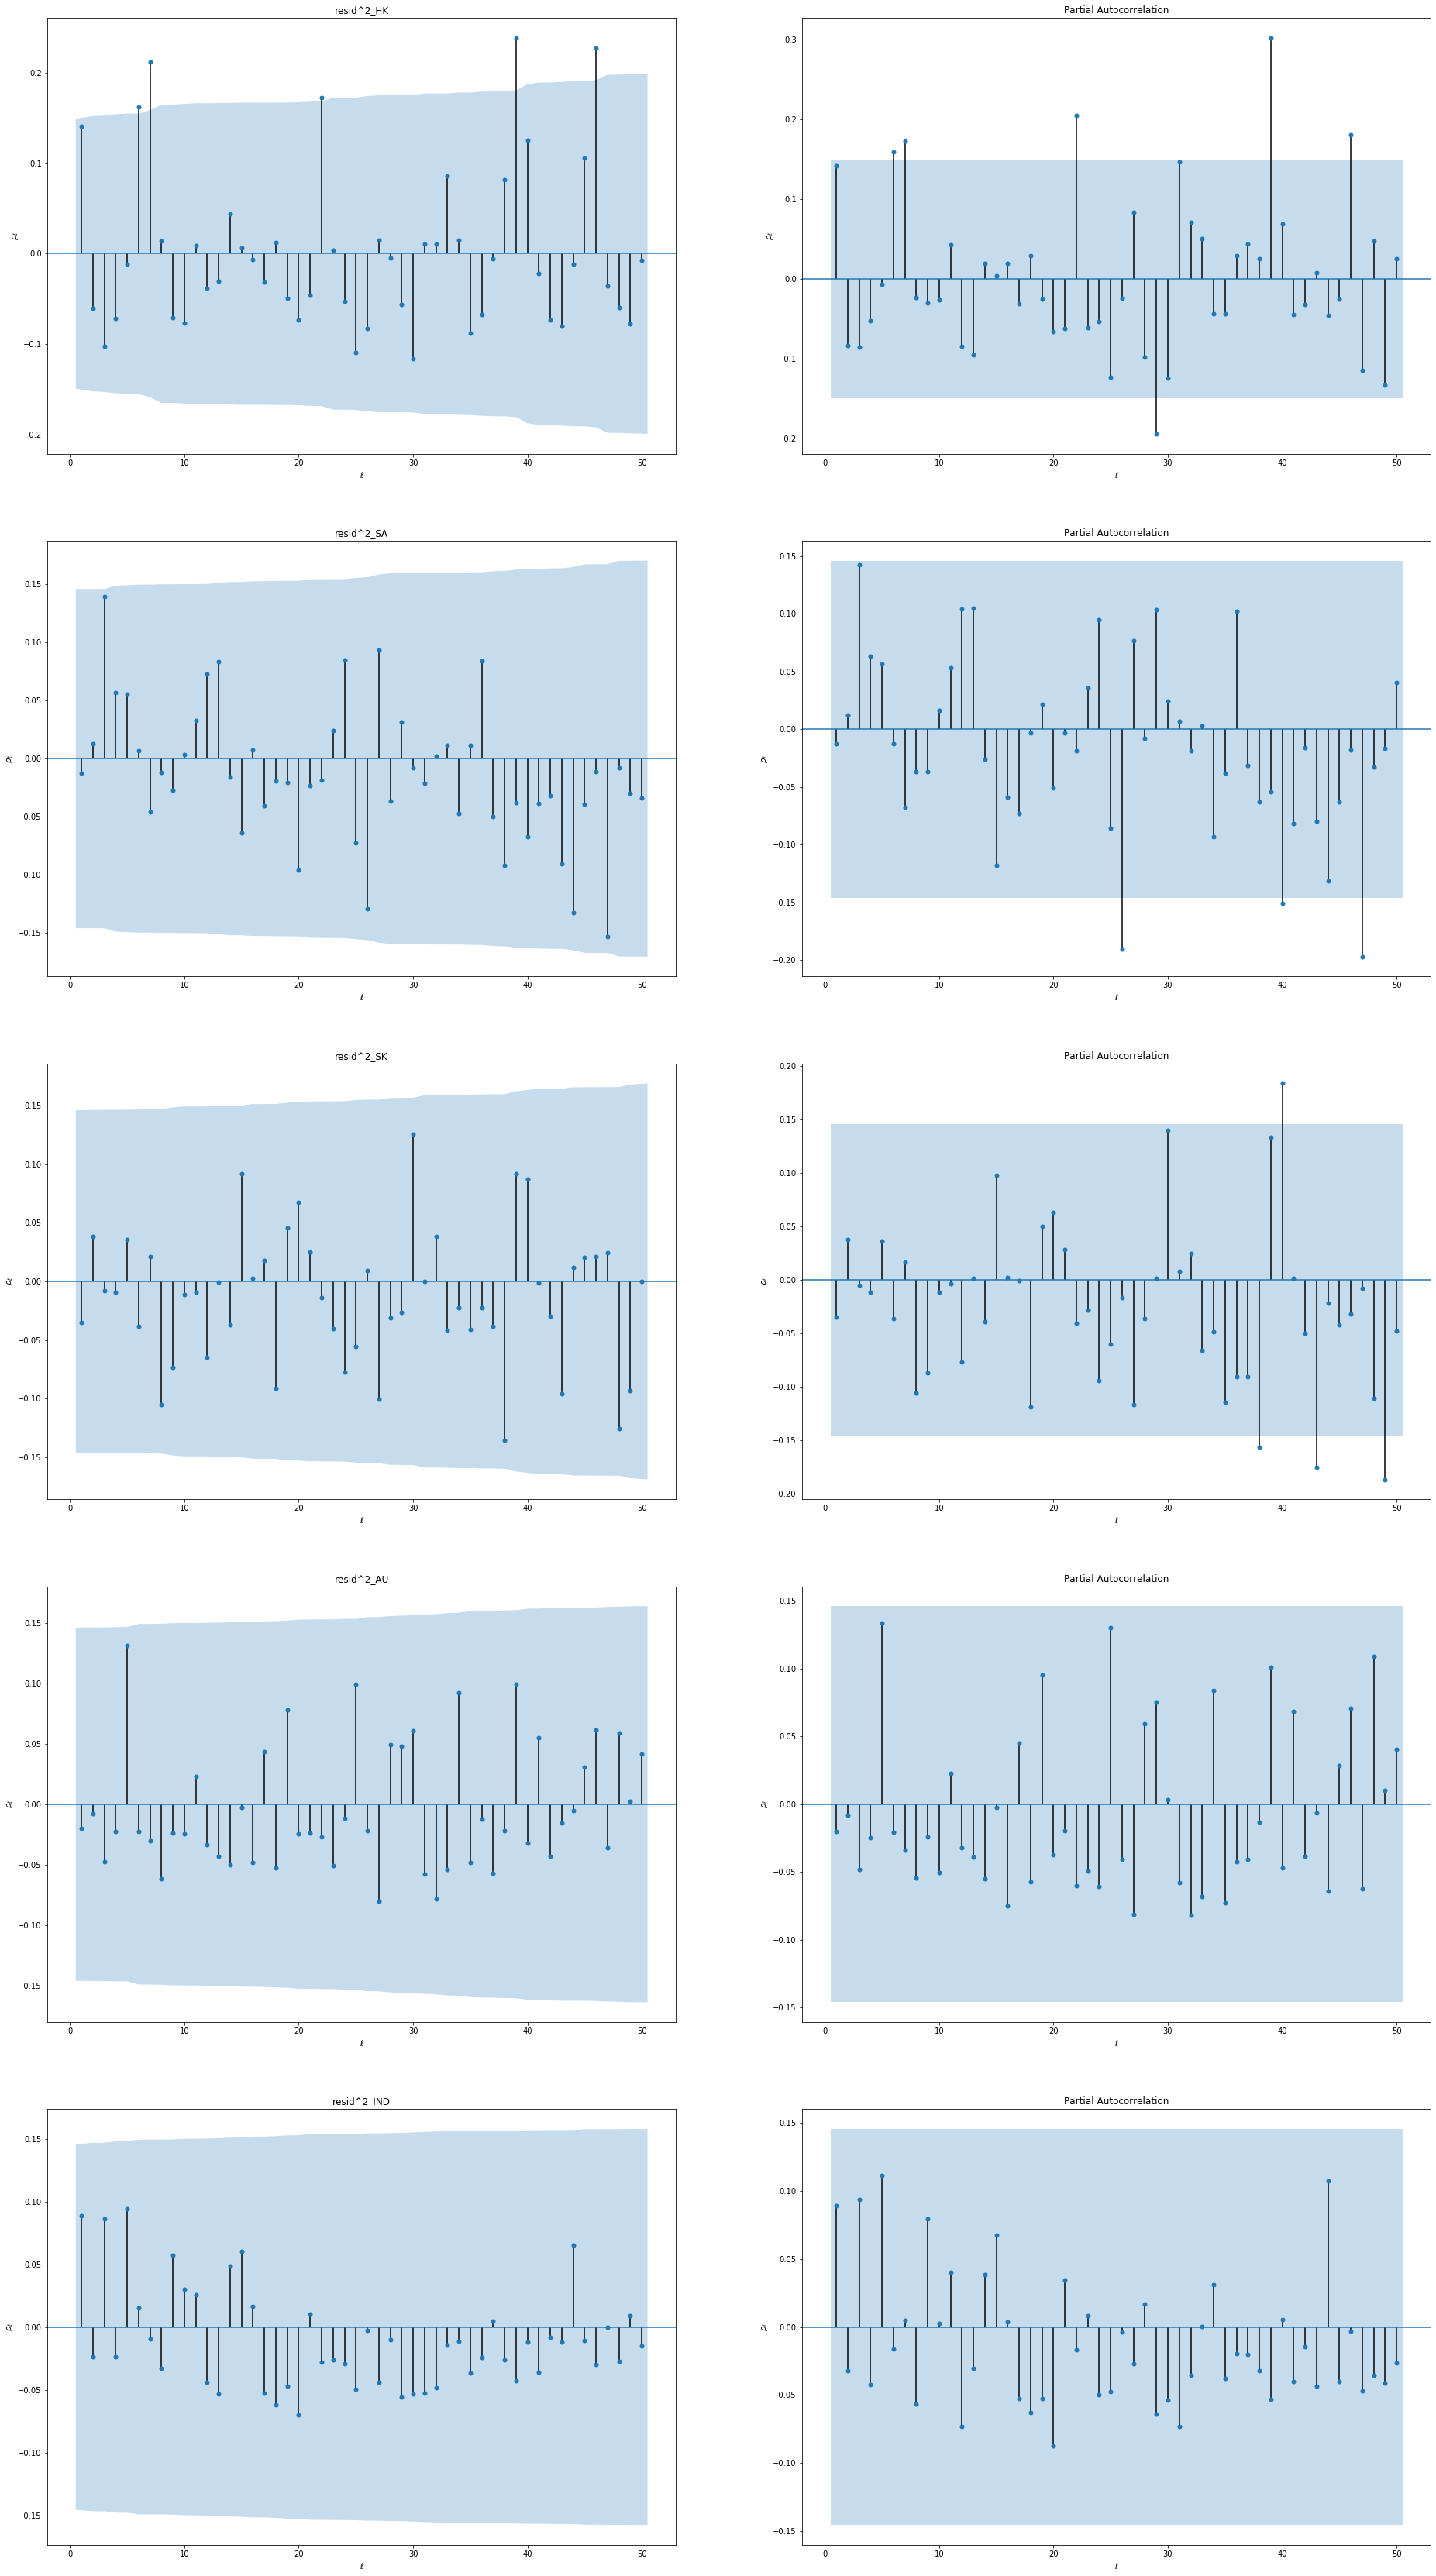

In [109]:
#Fit correlograms of resultant models (split into 2 figures in order to make easier positioning in the final thesis document)

fig,ax = plt.subplots(nrows=5, ncols=2, figsize=(32,60));
tsaplots.plot_acf(res_USA.resid.dropna()**2, lags=50, zero=False, ax = ax[0][0])
ax[0][0].set_title('resid^2_USA')
ax[0][0].set_ylabel(r'$\rho_\ell$')
ax[0][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_USA.resid.dropna()**2, lags=50, zero=False, ax = ax[0][1])
ax[0][1].set_ylabel(r'$\rho_\ell$')
ax[0][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(res_JAP.resid.dropna()**2, lags=50, zero=False, ax = ax[1][0])
ax[1][0].set_title('resid^2_JAP')
ax[1][0].set_ylabel(r'$\rho_\ell$')
ax[1][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_JAP.resid.dropna()**2, lags=50, zero=False, ax = ax[1][1])
ax[1][1].set_ylabel(r'$\rho_\ell$')
ax[1][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(res_NL.resid.dropna()**2, lags=50, zero=False, ax = ax[2][0])
ax[2][0].set_title('resid^2_NL')
ax[2][0].set_ylabel(r'$\rho_\ell$')
ax[2][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_NL.resid.dropna()**2, lags=50, zero=False, ax = ax[2][1])
ax[2][1].set_ylabel(r'$\rho_\ell$')
ax[2][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(res_GER.resid.dropna()**2, lags=50, zero=False, ax = ax[3][0])
ax[3][0].set_title('resid^2_GER')
ax[3][0].set_ylabel(r'$\rho_\ell$')
ax[3][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_GER.resid.dropna()**2, lags=50, zero=False, ax = ax[3][1])
ax[3][1].set_ylabel(r'$\rho_\ell$')
ax[3][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(res_BR.resid.dropna()**2, lags=50, zero=False, ax = ax[4][0])
ax[4][0].set_title('resid^2_BR')
ax[4][0].set_ylabel(r'$\rho_\ell$')
ax[4][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_BR.resid.dropna()**2, lags=50, zero=False, ax = ax[4][1])
ax[4][1].set_ylabel(r'$\rho_\ell$')
ax[4][1].set_xlabel(r'$\ell$');
tikz_save('correlograms1.tikz')

fig,ax = plt.subplots(nrows=5, ncols=2, figsize=(32,60));
tsaplots.plot_acf(res_HK.resid.dropna()**2, lags=50, zero=False, ax = ax[0][0])
ax[0][0].set_title('resid^2_HK')
ax[0][0].set_ylabel(r'$\rho_\ell$')
ax[0][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_HK.resid.dropna()**2, lags=50, zero=False, ax = ax[0][1])
ax[0][1].set_ylabel(r'$\rho_\ell$')
ax[0][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(res_SA.resid.dropna()**2, lags=50, zero=False, ax = ax[1][0])
ax[1][0].set_title('resid^2_SA')
ax[1][0].set_ylabel(r'$\rho_\ell$')
ax[1][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_SA.resid.dropna()**2, lags=50, zero=False, ax = ax[1][1])
ax[1][1].set_ylabel(r'$\rho_\ell$')
ax[1][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(res_SK.resid.dropna()**2, lags=50, zero=False, ax = ax[2][0])
ax[2][0].set_title('resid^2_SK')
ax[2][0].set_ylabel(r'$\rho_\ell$')
ax[2][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_SK.resid.dropna()**2, lags=50, zero=False, ax = ax[2][1])
ax[2][1].set_ylabel(r'$\rho_\ell$')
ax[2][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(res_AU.resid.dropna()**2, lags=50, zero=False, ax = ax[3][0])
ax[3][0].set_title('resid^2_AU')
ax[3][0].set_ylabel(r'$\rho_\ell$')
ax[3][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_AU.resid.dropna()**2, lags=50, zero=False, ax = ax[3][1])
ax[3][1].set_ylabel(r'$\rho_\ell$')
ax[3][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(res_IND.resid.dropna()**2, lags=50, zero=False, ax = ax[4][0])
ax[4][0].set_title('resid^2_IND')
ax[4][0].set_ylabel(r'$\rho_\ell$')
ax[4][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_IND.resid.dropna()**2, lags=50, zero=False, ax = ax[4][1])
ax[4][1].set_ylabel(r'$\rho_\ell$')
ax[4][1].set_xlabel(r'$\ell$');
tikz_save('correlograms2.tikz')

In [110]:
#Test chosen models for residual autocorrelation (Ljung-Box test)
name = ['LB Test', 'p-value', 'F-version', 'F p-value'];
stand_resid_USA = res_USA.resid.dropna()/res_USA.conditional_volatility.dropna();
stand_resid_JAP = res_JAP.resid.dropna()/res_JAP.conditional_volatility.dropna();
stand_resid_NL = res_NL.resid.dropna()/res_NL.conditional_volatility.dropna();
stand_resid_GER = res_GER.resid.dropna()/res_GER.conditional_volatility.dropna();
stand_resid_BR = res_BR.resid.dropna()/res_BR.conditional_volatility.dropna();
stand_resid_HK = res_HK.resid.dropna()/res_HK.conditional_volatility.dropna();
stand_resid_SA = res_SA.resid.dropna()/res_SA.conditional_volatility.dropna();
stand_resid_SK = res_SK.resid.dropna()/res_SK.conditional_volatility.dropna();
stand_resid_AU = res_AU.resid.dropna()/res_AU.conditional_volatility.dropna();
stand_resid_IND = res_IND.resid.dropna()/res_IND.conditional_volatility.dropna();

test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_USA); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_JAP); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_NL); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_GER); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_BR); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_HK); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_SA); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_SK); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_AU); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_IND); #0lags
print(lzip(name, test));

[('LB Test', array([ 2.94550896,  3.51596833,  3.58512733,  4.39962102,  5.63290638,
       12.05897215, 13.19477565, 14.77698829, 14.79554537, 14.81381975,
       16.0556383 , 17.45245557, 19.40370024, 20.44144234, 20.44343884,
       21.47465503, 24.66512496, 24.71958599, 27.94632663, 27.94643007,
       28.74327539, 29.79320615, 29.82620918, 29.85954111, 30.65035589,
       30.81260976, 30.87218112, 30.96660543, 33.07376545, 34.05762206,
       34.45387624, 35.17656121, 37.82068108, 37.83086032, 37.99492497,
       42.27319758, 42.92509425, 43.66172971, 43.82514023, 43.90177653])), ('p-value', array([0.08611657, 0.17239203, 0.30988806, 0.3546163 , 0.34359217,
       0.06066607, 0.06750255, 0.06362962, 0.09670727, 0.13899852,
       0.13907787, 0.13335535, 0.11110886, 0.11682672, 0.15557358,
       0.16097845, 0.10246007, 0.13283721, 0.08446704, 0.11067356,
       0.12030265, 0.12357782, 0.15445593, 0.1894508 , 0.20085869,
       0.23532229, 0.27641924, 0.31856543, 0.27477371, 0.2785

In [111]:
#Refit the models in the case of any changes due to tests and calculate model predictions
df2 = df.iloc[:,11:21].dropna()
df2.index = pd.to_datetime(df2.index)
mkt2=df2.iloc[:,9].dropna()
mkt2 = np.array(mkt2.values.tolist());
mkt2 = mkt2.reshape(len(mkt2), 1);

ls_USA2 = ARX(df2.log_ret_USA, mkt2, lags=[1,3,4,7,9,10,11,13], constant=True);
ls_USA2.distibution = 'Normal';
ls_USA2.volatility = GARCH(p=5,q=1);
res_USA2 = ls_USA2.fit(last_obs='2019-12-02', update_freq=0, disp='off');
forecasts_USA = res_USA2.forecast()
pred_USA = forecasts_USA.mean.iloc[:,0].dropna()

ls_JAP2 = ARX(df2.log_ret_JAP, mkt2, lags=[1,4,6,8,9,10,11,12,13,14,15], constant=True);
ls_JAP2.distibution = 'Normal';
ls_JAP2.volatility = GARCH(p=20,q=0);
res_JAP2 = ls_JAP2.fit(last_obs='2019-12-02', update_freq=0, disp='off');
forecasts_JAP = res_JAP2.forecast()
pred_JAP = forecasts_JAP.mean.iloc[:,0].dropna()

ls_NL2 = ARX(df2.log_ret_NL, mkt2, lags=[11,14], constant=True);
ls_NL2.distibution = 'Normal';
ls_NL2.volatility = GARCH(p=2, q=0);
res_NL2 = ls_NL2.fit(last_obs='2019-12-02', update_freq=0, disp='off');
forecasts_NL = res_NL2.forecast()
pred_NL = forecasts_NL.mean.iloc[:,0].dropna()

ls_GER2 = ARX(df2.log_ret_GER, mkt2, lags=[1,2,10], constant=True);
ls_GER2.distibution = 'Normal';
ls_GER2.volatility = GARCH(p=5,q=2);
res_GER2 = ls_GER2.fit(last_obs='2019-12-02', update_freq=0, disp='off');
forecasts_GER = res_GER2.forecast()
pred_GER = forecasts_GER.mean.iloc[:,0].dropna()

ls_BR2 = LS(df2.log_ret_BR, mkt2, constant=True);
ls_BR2.distibution = 'Normal';
ls_BR2.volatility = GARCH(p=1,q=0);
res_BR2 = ls_BR2.fit(last_obs='2019-12-02', update_freq=0, disp='off');
forecasts_BR = res_BR2.forecast()
pred_BR = forecasts_BR.mean.iloc[:,0].dropna()

ls_HK2 = ARX(df2.log_ret_HK, mkt2, lags=[1,3,8], constant=True);
ls_HK2.distibution = 'Normal';
ls_HK2.volatility = GARCH(p=8,q=2);
res_HK2 = ls_HK2.fit(last_obs='2019-12-02', update_freq=0, disp='off');
forecasts_HK = res_HK2.forecast()
pred_HK = forecasts_HK.mean.iloc[:,0].dropna()

ls_SA2 = ARX(df2.log_ret_SA, mkt2, lags=1, constant=True);
ls_SA2.distibution = 'Normal';
ls_SA2.volatility = GARCH(p=3,q=2);
res_SA2 = ls_SA2.fit(last_obs='2019-12-02', update_freq=0, disp='off');
forecasts_SA = res_SA2.forecast()
pred_SA = forecasts_SA.mean.iloc[:,0].dropna()

ls_SK2 = ARX(df2.log_ret_SK, mkt2, lags=1, constant=True);
ls_SK2.distibution = 'Normal';
ls_SK2.volatility = GARCH(p=2,q=0);
res_SK2 = ls_SK2.fit(last_obs='2019-12-02', update_freq=0, disp='off');
forecasts_SK = res_SK2.forecast()
pred_SK = forecasts_SK.mean.iloc[:,0].dropna()

ls_AU2 = ARX(df2.log_ret_AU, mkt2, lags=1, constant=True);
ls_AU2.distibution = 'Normal';
ls_AU2.volatility = GARCH(p=2,q=3);
res_AU2 = ls_AU2.fit(last_obs='2019-12-02', update_freq=0, disp='off');
forecasts_AU = res_AU2.forecast()
pred_AU = forecasts_AU.mean.iloc[:,0].dropna()

ls_IND2 = LS(df2.log_ret_IND, mkt2, constant=True);
ls_IND2.distibution = 'Normal';
ls_IND2.volatility = GARCH(p=3,q=1);
res_IND2 = ls_IND2.fit(last_obs='2019-12-02', update_freq=0, disp='off');
forecasts_IND = res_IND2.forecast()
pred_IND = forecasts_IND.mean.iloc[:,0].dropna()

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.6333. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8848. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataSc

In [112]:
#Combine forecasts to create a dataset of model predictions
er=np.zeros((len(df_test2.index),10))

er[:,0]=pred_USA
er[:,1]=pred_JAP
er[:,2]=pred_NL
er[:,3]=pred_GER
er[:,4]=pred_BR
er[:,5]=pred_HK
er[:,6]=pred_SA
er[:,7]=pred_SK
er[:,8]=pred_AU
er[:,9]=pred_IND

er=pd.DataFrame(er,index=df_test2.index,columns=df_test2.columns)
print(er)

              log_ret_USA  log_ret_JAP  log_ret_NL  log_ret_GER  log_ret_BR  \
Date                                                                          
Dec 02, 2019     0.209491     0.253557    0.083664     0.070418    0.135031   
Dec 03, 2019     0.281425     0.068380   -0.008482     0.233696    0.174304   
Dec 04, 2019     0.165798     0.248991    0.126244     0.394712    0.141292   
Dec 05, 2019     0.138947     0.060320    0.093595    -0.145998    0.224595   
Dec 06, 2019     0.135942    -0.220591    0.074409    -0.186377    0.021124   
Dec 09, 2019     0.109996    -0.023335    0.166361     0.123008    0.165247   
Dec 10, 2019     0.181926    -0.332198    0.061320    -0.019785   -0.007197   
Dec 11, 2019     0.428453     0.140283    0.185292     0.234433    0.111657   
Dec 12, 2019     0.330641     0.174474    0.255934     0.044877    0.181363   
Dec 13, 2019     0.317729     0.426804    0.197460    -0.119687    0.376135   
Dec 17, 2019     0.257002     0.048563    0.169448  

In [113]:
#Calculate individual stock-index standard deviations
s_j=np.zeros(10)
T=len(df_tr2.index)

sd_USA=np.sqrt(sum(res_USA.resid.dropna()**2)/(T-1))
sd_JAP=np.sqrt(sum(res_JAP.resid.dropna()**2)/(T-1))
sd_NL=np.sqrt(sum(res_NL.resid.dropna()**2)/(T-1))
sd_GER=np.sqrt(sum(res_GER.resid.dropna()**2)/(T-1))
sd_BR=np.sqrt(sum(res_BR.resid.dropna()**2)/(T-1))
sd_HK=np.sqrt(sum(res_HK.resid.dropna()**2)/(T-1))
sd_SA=np.sqrt(sum(res_SA.resid.dropna()**2)/(T-1))
sd_SK=np.sqrt(sum(res_SK.resid.dropna()**2)/(T-1))
sd_AU=np.sqrt(sum(res_AU.resid.dropna()**2)/(T-1))
sd_IND=np.sqrt(sum(res_IND.resid.dropna()**2)/(T-1))

s_j[0]=sd_USA
s_j[1]=sd_JAP
s_j[2]=sd_NL
s_j[3]=sd_GER
s_j[4]=sd_BR
s_j[5]=sd_HK
s_j[6]=sd_SA
s_j[7]=sd_SK
s_j[8]=sd_AU
s_j[9]=sd_IND

In [114]:
#Calculate the indices' Abnormal Returns (actual returns over test period - expected returns)
ar=df_test2.subtract(er)
print(ar)

              log_ret_USA  log_ret_JAP  log_ret_NL  log_ret_GER  log_ret_BR  \
Date                                                                          
Dec 02, 2019    -1.076340     0.752742   -1.801014    -1.433456    0.803701   
Dec 03, 2019    -0.947447    -0.706590   -0.707730     0.259133   -0.225664   
Dec 04, 2019     0.464568    -1.300618    1.246954     0.439389    1.040632   
Dec 05, 2019     0.010966     0.649744   -0.017478    -0.143333    0.066004   
Dec 06, 2019     0.773483     0.453411    1.745130     0.475708    0.433447   
Dec 09, 2019    -0.426779     0.349502   -0.172998    -0.637151   -0.299419   
Dec 10, 2019    -0.291679     0.244626   -0.448950    -0.027416   -0.268013   
Dec 11, 2019    -0.138060    -0.218614   -0.347104     0.579388    0.151838   
Dec 12, 2019     0.523226    -0.033707   -0.130796     0.923049    0.926354   
Dec 13, 2019    -0.310471     2.095207    0.326413     0.795238   -0.051351   
Dec 17, 2019     0.488758     0.130352    0.387997  

In [115]:
#Calculate the Standardized Abnormal Returns and Cumulative Abnormal Returns 
t=len(df_test2.index)
s_jt=np.zeros((t,10))
rm=df_tr.iloc[:,21].dropna()
mean_rm=np.mean(rm)
denom=sum((rm-mean_rm)**2)
r_mt=df_test.iloc[:,21].dropna()
for j in range(10):
    s_jt[:,j]=np.sqrt(s_j[j]**2*(1+(1/T)+(((r_mt-mean_rm)**2)/denom)))
s_jt=pd.DataFrame(s_jt,index=ret_test.index,columns=ret_test.columns)
sar=ar.divide(s_jt)
car=np.zeros(10)
for j in range(10):
    car[j]=(1/np.sqrt(t))*sum(sar.iloc[:,j])
print(car)

[-2.68521379 -1.87791912 -2.89006239 -2.04419666 -1.96172105 -0.22327556
  0.64238752  0.38332119 -2.76234104  2.2625347 ]


In [116]:
#Test the significance of the Cumulative Abnormal Returns

print('t-statistic = %6.3f pvalue = %6.4f' %  stats.ttest_1samp(car, 0))

#Test to see the significance excluding India's results
print('t-statistic = %6.3f pvalue = %6.4f' %  stats.ttest_1samp(car[0:8], 0))

t-statistic = -1.999 pvalue = 0.0767
t-statistic = -2.710 pvalue = 0.0302


In [117]:
#Make changes to South-Korea and Australia's models based on results of MM-EGARCH findings (in a different .ipynb file)
ls_SK2 = ARX(df2.log_ret_SK, mkt2, lags=[5], constant=True);
ls_SK2.distibution = 'StudentsT';
ls_SK2.volatility = EGARCH(p=1,q=1,o=1);
res_SK2 = ls_SK2.fit(last_obs='2019-12-02', update_freq=0, disp='off');
forecasts_SK = res_SK2.forecast()
pred_SK = forecasts_SK.mean.iloc[:,0].dropna()

ls_AU2 = ARX(df2.log_ret_AU, mkt2, lags=[2,3,4,5,6,7,8,9,10,11,12], constant=True);
ls_AU2.distibution = 'Normal';
ls_AU2.volatility = EGARCH(p=2,q=1,o=1);
res_AU2 = ls_AU2.fit(last_obs='2019-12-02', update_freq=0, disp='off');
forecasts_AU = res_AU2.forecast()
pred_AU = forecasts_AU.mean.iloc[:,0].dropna()


#Calculate resulting cumulative abnormal results and test for significance
er=np.zeros((len(df_test2.index),10))

er[:,0]=pred_USA
er[:,1]=pred_JAP
er[:,2]=pred_NL
er[:,3]=pred_GER
er[:,4]=pred_BR
er[:,5]=pred_HK
er[:,6]=pred_SA
er[:,7]=pred_SK
er[:,8]=pred_AU
er[:,9]=pred_IND

er=pd.DataFrame(er,index=df_test2.index,columns=df_test2.columns)

ar=df_test2.subtract(er)

t=len(df_test2.index)
s_jt=np.zeros((t,10))
rm=df_tr.iloc[:,21].dropna()
mean_rm=np.mean(rm)
denom=sum((rm-mean_rm)**2)
r_mt=df_test.iloc[:,21].dropna()
for j in range(10):
    s_jt[:,j]=np.sqrt(s_j[j]**2*(1+(1/T)+(((r_mt-mean_rm)**2)/denom)))
s_jt=pd.DataFrame(s_jt,index=ret_test.index,columns=ret_test.columns)
sar=ar.divide(s_jt)
car=np.zeros(10)
for j in range(10):
    car[j]=(1/np.sqrt(t))*sum(sar.iloc[:,j])
print(car)

print('t-statistic = %6.3f pvalue = %6.4f' %  stats.ttest_1samp(car, 0))

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8321. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.6682. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


[-2.68521379 -1.87791912 -2.89006239 -2.04419666 -1.96172105 -0.22327556
  0.64238752 -0.54089711 -5.57128325  2.2625347 ]
t-statistic = -2.183 pvalue = 0.0569


Interesting to note that it is now HK and SA which show positive results.